In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [27]:
# We create the image generators for training, validation and testing, scaling the tensors to values between 0 and 1
train_image_generator = ImageDataGenerator(rescale = 1. / 255)
validation_image_generator = ImageDataGenerator(rescale = 1. / 255)
test_image_generator = ImageDataGenerator(rescale = 1. / 255)

# We read the images from the folders containing the images
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = batch_size,
    class_mode = "binary"
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = batch_size,
    class_mode = "binary"
)

test_data_gen = test_image_generator.flow_from_directory(
    PATH,
    classes=['test'],
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    shuffle = False,
    batch_size = 1,
    class_mode = None
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [39]:
# We create the train images generator again, but this time with random transformations in order to have more training examples
train_image_generator = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    shear_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
    )

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
    )

Found 2000 images belonging to 2 classes.


In [ ]:
# We check if the transformations worked correctly
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [50]:
# We create the model for the neural network

# First the fully connected layer that finds the features
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64, (5,5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64, (5,5), activation='relu'))

# Then the dense layers which predict a class cat or dog
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# We compile the model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.binary_crossentropy,
    metrics = ['accuracy']
    )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 69, 69, 64)        51264     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 34, 34, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 64)        102464    
                                                                 
 flatten_4 (Flatten)         (None, 57600)            

In [51]:
# We train the model
history = model.fit(
    x = train_data_gen,
    epochs = epochs,
    steps_per_epoch = 10,
    validation_data = val_data_gen,
    validation_steps = total_val // batch_size
)

Epoch 1/15
10/10 [==============================] - 131s 13s/step - loss: 0.7884 - accuracy: 0.4943 - val_loss: 0.6864 - val_accuracy: 0.5603
Epoch 2/15
10/10 [==============================] - 154s 16s/step - loss: 0.6875 - accuracy: 0.5352 - val_loss: 0.6905 - val_accuracy: 0.5011
Epoch 3/15
10/10 [==============================] - 131s 13s/step - loss: 0.6776 - accuracy: 0.5711 - val_loss: 0.6533 - val_accuracy: 0.5982
Epoch 4/15
10/10 [==============================] - 125s 12s/step - loss: 0.6688 - accuracy: 0.5649 - val_loss: 0.6392 - val_accuracy: 0.6228
Epoch 5/15
10/10 [==============================] - 122s 12s/step - loss: 0.6637 - accuracy: 0.5844 - val_loss: 0.6973 - val_accuracy: 0.5502
Epoch 6/15
10/10 [==============================] - 120s 12s/step - loss: 0.6668 - accuracy: 0.5722 - val_loss: 0.6411 - val_accuracy: 0.6172
Epoch 7/15
10/10 [==============================] - 121s 12s/step - loss: 0.6642 - accuracy: 0.5877 - val_loss: 0.6715 - val_accuracy: 0.5435
Epoch 

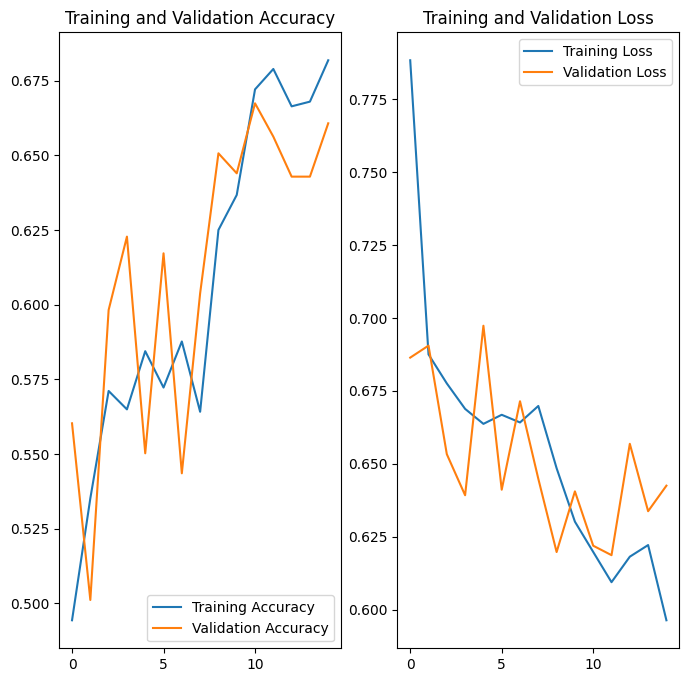

In [52]:
# We check some of the parameters throughout training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# We predict some random images

probabilities = model.predict(test_data_gen)
plotImages(sample_training_images[:20], probabilities)

In [56]:

answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
